# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

(Solved during class)
We scale down $p_i$, by setting $\hat{p_i} = p_i / (1+\varepsilon)$. We have $\hat{p_i} \le q_i$.
Now sample with probabilities $q_i$. Say $k$ is sampled. 
Toss a coin, and with probability $\hat{p_k}/q_k$ pick $k$, otherwise repeat.
The proof is a simple application of conditional probabilities.
Also, this works in expected $O(1)$, but we do not yet know expectation, so do not elaborate on this too much.
The idea used here is very simple but very potent. It appears again and again in theory and probably in practice
too.

Here is an important point: you can use this scheme without knowing all the $p_i$, it is enough 
to know that $p_i$ and $q_i$ are close. This can be very useful, when $n$ is very large, but $p_i$ have 
no structure to exploit, etc.

Another nice feature of this scheme is that it very naturally handles small changes to $p_i$. For example, in our
problem, we might choose to actually sample PEOPLE and not dates. This would require decreasing birth counters
after each sample is taken. The results would obviously be almost the same, since these numbers are really large, 
but if we insist on doing this, this method would be the way to go.

The birthday setting does not satisfy the $\varepsilon$-condition for any reasonably small epsilon, mainly 
because of the outliers (errors). But the algorithm still works, the running time is actually smaller than 
for the binarysearch version (but only slightly). Why does it work?

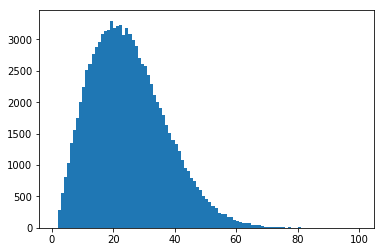

[19, 22, 21, 20, 24, 18, 17, 16, 25, 23, 26, 15, 27, 14, 13, 28, 12, 29, 30, 11, 31, 32, 10, 33, 34, 9, 35, 36, 8, 37, 7, 38, 39, 6, 40, 41, 42, 5, 43, 44, 4, 45, 46, 47, 48, 3, 49, 50, 51, 52, 53, 2, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 63, 66, 67, 65, 68, 70, 69, 71, 72, 73, 74, 75, 77, 80, 76, 78, 79, 82, 84, 83]
24.59017


In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
stats = np.loadtxt('us_births_69_88.csv',skiprows=1,delimiter=',',dtype=int)


def empDates(dCnt,bMax):
    s = set()
    for k in range(dCnt):
        while True:
            day = random.randint(0,dCnt-1)
            if random.randint(1,bMax) <= stats[day,2]:
                break
        if day in s:
            return k+1
        else:
            s.add(day)
            
            
dCnt = stats.shape[0]
bMax = np.max(stats[:,2])
            
empSample = [empDates(dCnt,bMax) for iter in range(100000)]
# %timeit empSample = [empDates(dCnt,bMax) for iter in range(100000)]

plt.hist(empSample,bins=range(1,101))
plt.show()

k_counts = sorted(list(set(empSample)), key=empSample.count, reverse=True)
print(k_counts)

print(sum(empSample)/len(empSample))


**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [20]:
X = np.array([10,3,7])
I = np.array([1,1,2,2])
print(X[I])
X = np.array([[1,2],[3,4]])
I = np.array([0,0,1])
J = np.array([1,0,1])
print(X[I,J])

[3 3 7 7]
[2 1 4]


212915


**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

**Proof**:
* **Algorithm always ends.**

In every step we transfer probability from an overflowing bucket B to the bucket A that is not full, making it exactly full. Hence, with every iteration we get one step closer to the desired state. This algorithm always ends as for every bucket that is not full there will always be at least one that is overflowing since the sum of all probabilities $p_1+\ldots+p_n$= $n\frac{1}{n}$.

* **Each bucket contains pieces of maximum two $p_i$'s.**

First, let's see why the statement "each bucket contains piece of exactly two $p_i$'s" is not really true. Suppose we have just two buckets and $p_1 = 0.50 + x$, $p_2 = 0.50 - x$. It is clear that by transferring $x$ from the overflowing bucket to the other one, we come to the desired state and the first bucket contains probability of just one $p_i$.  
Now, let's prove the statement.  
Suppose we have a bucket $b_i$ that is not full. We already know that there must exist a bucket $b_k$ that is overflowing. So let's transfer probability from $b_k$ to $b_i$. $b_i$ is now exactly full and contatins pieces of two buckets - itself and $b_k$, and since it is exactly full, we will never make any changes to it in the future.  
For $b_k$ there are two scenarios - it might be exactly full or not full after the transfer. In the first case, no changes are needed, hence $b_k$ contains probability of exactly one bucket. In the second case, we follow the exact same steps as for $b_i$, so that in the end $b_k$ contains probabilities of two buckets.

* **The algorithm for sampling.**

Let's use the square histogram method described here http://www.robertowor.com/csci4151/lecture3.htm. By creating a square with area filled with probabilities  $p_1,\ldots,p_n$ we are able to sample with given probabilities: we uniformally choose a point in the square and depending on where it lays, it is asssigned to one of the given probabilities.

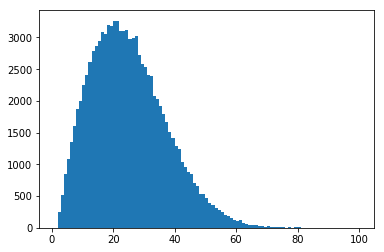

24.60311


In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
stats = np.loadtxt('us_births_69_88.csv',skiprows=1,delimiter=',',dtype=int)

birthsCount = sum(stats[:,2])
daysCount = stats.shape[0]
probability = np.array(stats[:,2]/birthsCount)
avgProbability = 1/daysCount

bottomBin = probability
borrowedFrom = np.zeros(bottomBin.shape[0])
borrowedFrom.fill(-1)
divider = np.zeros(bottomBin.shape[0])

def squareHistogram():
    while (len(np.argwhere(bottomBin < avgProbability)) > 0):
        toIndex = np.argwhere(bottomBin < avgProbability)[0,0]
        if (len(np.argwhere(bottomBin > avgProbability)) > 0):
            fromIndex = np.argwhere(bottomBin > avgProbability)[0,0]
            borrowedFrom[toIndex] = fromIndex
            bottomBin[fromIndex] -= (avgProbability - bottomBin[toIndex])
            divider[toIndex] = bottomBin[toIndex]
            bottomBin[toIndex] = avgProbability
        else:
            #due to floating-point numbers we need to set last bin manually
            bottomBin[toIndex] = avgProbability
            divider[toIndex] = bottomBin[toIndex]
            
    
    
def empDates(i, daysCount):
    s = set()

    for k in range(daysCount):
        binNo = random.randint(0, daysCount-1)
        pointHeight = random.uniform(0, avgProbability)
        
        if divider[binNo] != 0 and pointHeight <= divider[binNo]:
            day = binNo
        else:
            day = borrowedFrom[binNo]

        if day in s:
            return k+1
        else:
            s.add(day)
                
squareHistogram()
empSampleVector = np.vectorize(empDates)
empSample = empSampleVector(np.zeros(100000), daysCount)

# %timeit empSample = empSampleVector(np.zeros(100000), daysCount)

plt.hist(empSample,bins=range(1,101))
plt.show()

print(sum(empSample)/len(empSample))


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.

**BONUS**. An alternative plotting library: plotly

In [ ]:
#install plotly with: pip install plotly
#you can run this shell command directly from Jupyter, by prefixing it with !
!pip install plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import numpy as np

init_notebook_mode(connected=True)

# example scatterplot

x = np.linspace(0, 1, 10)
y = x * x

iplot([go.Scatter(x=x, y=y, name="y=x^2"), go.Scatter(x=x, y=-y, name="y=-x^2")])

# example heatmap

iplot([go.Heatmap(z=[[10, 20, 30, 40],
                      [20, 30, 40, 50],
                      [30, 40, 50, 60]])])
